In [1]:
library(tidyverse)
library(RColorBrewer)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
options(repr.plot.width = 8, repr.plot.height = 8)

sws_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.switzerland.data"
clv_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.cleveland.data"
hgr_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.hungarian.data"
vlb_url <- "https://raw.github.com/aaelbaz/DSCI-100-Group-Project/215e081060c7280c1d975721f1934d3c147aa8fe/heart_disease_data/processed.va.data"

cols <- c("age", "sex", "cp_type", "rest_bp", "cholesterol", "fbs", "rest_ecg", "max_hr",
          "exercise_angina", "st_depression", "st_slope", "coloured_vsls", "thal", "heart_disease")
na_vals <- c("", "NA", "?", -9.0)

sws <- read_csv(sws_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "Switzerland")
clv <- read_csv(clv_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "Cleveland")
hgr <- read_csv(hgr_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "Hungary")
vlb <- read_csv(vlb_url, col_names = cols, na = na_vals, show_col_types = FALSE) |> mutate(location = "VA Long Beach")

heart_disease_data <- bind_rows(sws, clv, hgr, vlb)

heart_disease_data$sex <- ifelse(heart_disease_data$sex == 0, "female", "male")
heart_disease_data$cp_type <- ifelse(heart_disease_data$cp_type == 1, "anginal",
                                     ifelse(heart_disease_data$cp_type == 2, "anginal",
                                            ifelse(heart_disease_data$cp_type == 3, "non-anginal", "asymptomatic")))
heart_disease_data$rest_ecg <- ifelse(heart_disease_data$rest_ecg == 0, "normal",
                                      ifelse(heart_disease_data$rest_ecg == 1, "abnormality", "hypertrophy"))
heart_disease_data$exercise_angina <- ifelse(heart_disease_data$exercise_angina == 0, "no", "yes")
heart_disease_data$st_slope <- ifelse(heart_disease_data$st_slope == 1, "upsloping",
                                      ifelse(heart_disease_data$st_slope == 2, "flat", "downsloping"))
heart_disease_data$thal <- ifelse(heart_disease_data$thal == 3, "normal",
                                      ifelse(heart_disease_data$thal == 6, "fixed", "reversable"))

heart_disease_data <- heart_disease_data |> 
    mutate(sex = as.factor(sex), cp_type = as.factor(cp_type), fbs = as.factor(fbs), rest_ecg = as.factor(rest_ecg),
       exercise_angina = as.factor(exercise_angina), st_slope = as.factor(st_slope), thal = as.factor(thal),
       heart_disease = as.factor(heart_disease), location = as.factor(location))

head(heart_disease_data)

age,sex,cp_type,rest_bp,cholesterol,fbs,rest_ecg,max_hr,exercise_angina,st_depression,st_slope,coloured_vsls,thal,heart_disease,location
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<fct>
32,male,anginal,95,0,NA,normal,127,no,0.7,upsloping,NA,NA,1,Switzerland
34,male,asymptomatic,115,0,NA,NA,154,no,0.2,upsloping,NA,NA,1,Switzerland
35,male,asymptomatic,NA,0,NA,normal,130,yes,NA,NA,NA,reversable,3,Switzerland
36,male,asymptomatic,110,0,NA,normal,125,yes,1.0,flat,NA,fixed,1,Switzerland
38,female,asymptomatic,105,0,NA,normal,166,no,2.8,upsloping,NA,NA,2,Switzerland
38,female,asymptomatic,110,0,0,normal,156,no,0.0,flat,NA,normal,1,Switzerland


To work with the data, we will first perform data wrangling tasks in order to narrow down our focus onto the variables of interest. To do this, we will first select for the class variable: cy_type, as well as the three of our predictor variables. In order for the k-nearest neighbor classifying model to work, the observations with NA appearing in any of the predictor variables will be removed. (How does this affect our data analysis?) 

In [3]:
heart_disease_clean <- heart_disease_data |>
    select(age, cp_type, rest_bp, max_hr)|>
    filter(!is.na(rest_bp),
           !is.na(age),
           !is.na(max_hr),
           !is.na(cp_type))
head(heart_disease_clean)

age,cp_type,rest_bp,max_hr
<dbl>,<fct>,<dbl>,<dbl>
32,anginal,95,127
34,asymptomatic,115,154
36,asymptomatic,110,125
38,asymptomatic,105,166
38,asymptomatic,110,156
38,non-anginal,100,179


To create our model of classification using this heart disease data set, we will first be splitting the data set into a training set and a test set, which allows us to check the performance based on the accuracy with predicting the classification on the testing set. 

In [4]:
heart_disease_split <- initial_split(heart_disease_clean, prop = 0.75, strata = cp_type)  
heart_disease_train <- training(heart_disease_split)   
heart_disease_test <- testing(heart_disease_split)

Tuning the classifer is one of the most essential step in data analysis. Before we build our model, we will tune our model by choosing the best K value (number of nearest neighbor) using cross-validation and measuring the accuracy. The process of cross-validation using the function vfold_cv utilizes randomness. By setting a seed that is fixed for the rest of the data analysis, we will ensure that the analysis performed effectively uses randomness while maintaining reproducibility.

In [9]:
set.seed(1234)

test_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_recipe <-recipe(cp_type ~ age + rest_bp + max_hr, data= heart_disease_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

heart_vfold <- vfold_cv(heart_disease_train, v = 4, strata = cp_type)

k_vals <- tibble(neighbors = seq(1, 100, 10))

heart_results <- workflow() |>
                 add_recipe(heart_recipe) |>
                 add_model(test_spec) |>
                 tune_grid(resamples = heart_vfold, grid = k_vals)|>
                 collect_metrics()

k_min <- heart_results |>
    filter(.metric == 'accuracy')|>
    arrange(desc(mean))|>
    slice(1)|>
    select(neighbors)|>
    pull()
k_min

[1] 81

After an optimal K value is chosen, we will be able to build our classification model using this K value as the number of nearest neighbor. To test the performance of this classification model, predictions were made on our testing data set and by comparing the predicted class and the actual class of chest pain type, the accuracy of our model was analyzed.  

In [7]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) |>
    set_engine("kknn") |>
    set_mode("classification")

best_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit(heart_disease_train)

heart_disease_predictions <- best_fit |>
    predict(heart_disease_test)|>
    bind_cols(heart_disease_test)|>
    metrics(truth = cp_type, estimate = .pred_class) |>
    filter(.metric == "accuracy")
heart_disease_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5990783


This table of summarization: 

In [10]:
anginal_rows_missing_data <- sum(!complete.cases(filter(heart_disease_train, cp_type == "anginal")))
non_anginal_rows_missing_data <- sum(!complete.cases(filter(heart_disease_train, cp_type == "non-anginal")))
asymptomatic_rows_missing_data <- sum(!complete.cases(filter(heart_disease_train, cp_type == "asymptomatic")))

cp_type_summarize <- heart_disease_train |> group_by(cp_type) |>
                        summarize(avg_rest_bp = mean(rest_bp, na.rm = TRUE), avg_max_hr = mean(max_hr, na.rm = TRUE), avg_age = mean(age, na.rm = TRUE), num_cases = n()) |>
                        bind_cols(tibble(rows_missing_data = c(anginal_rows_missing_data, non_anginal_rows_missing_data, asymptomatic_rows_missing_data)))

cp_type_summarize

cp_type,avg_rest_bp,avg_max_hr,avg_age,num_cases,rows_missing_data
<fct>,<dbl>,<dbl>,<dbl>,<int>,<int>
anginal,131.8141,150.7821,49.94231,156,0
asymptomatic,131.5229,129.2400,54.25429,350,0
non-anginal,129.7536,143.8913,53.22464,138,0


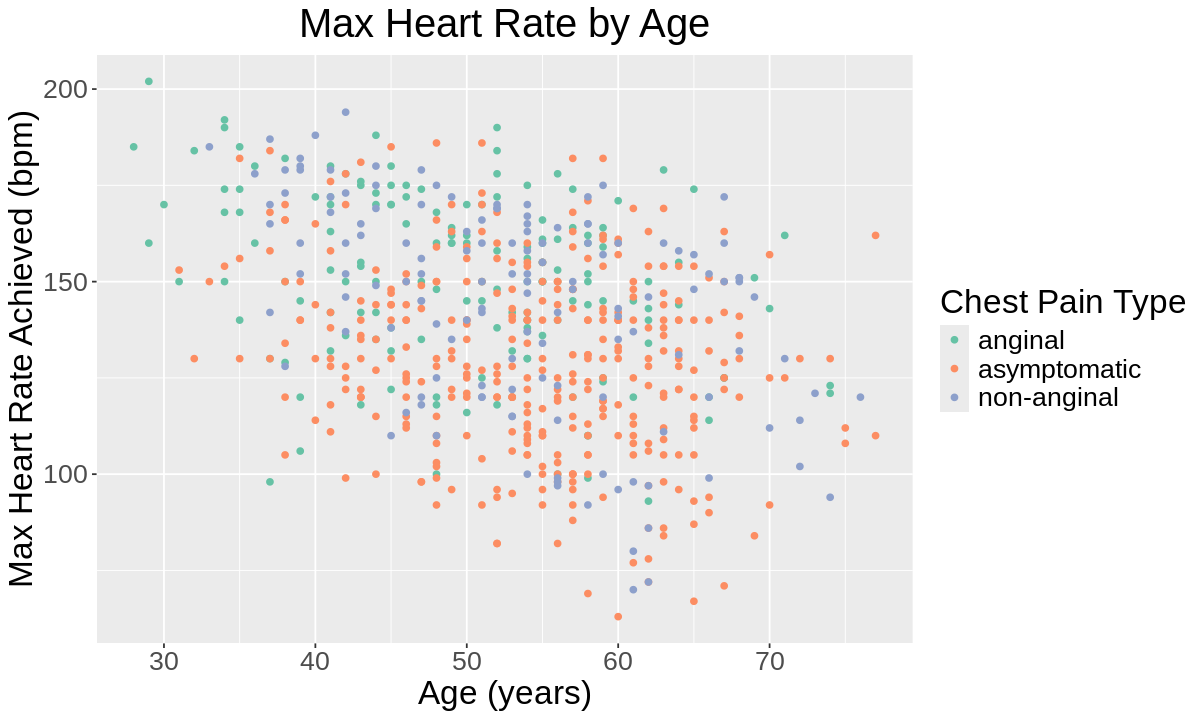

In [11]:
options(repr.plot.width = 10, repr.plot.height= 6)

heart_plot <- heart_disease_train |>
    ggplot(aes(x = age, y = max_hr, color = cp_type)) +
    geom_point() +
    labs(x = "Age (years)", y = "Max Heart Rate Achieved (bpm)", color = "Chest Pain Type") +
    ggtitle("Max Heart Rate by Age") +
    scale_color_brewer(palette = "Set2") +
    theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))

suppressWarnings(print(heart_plot))

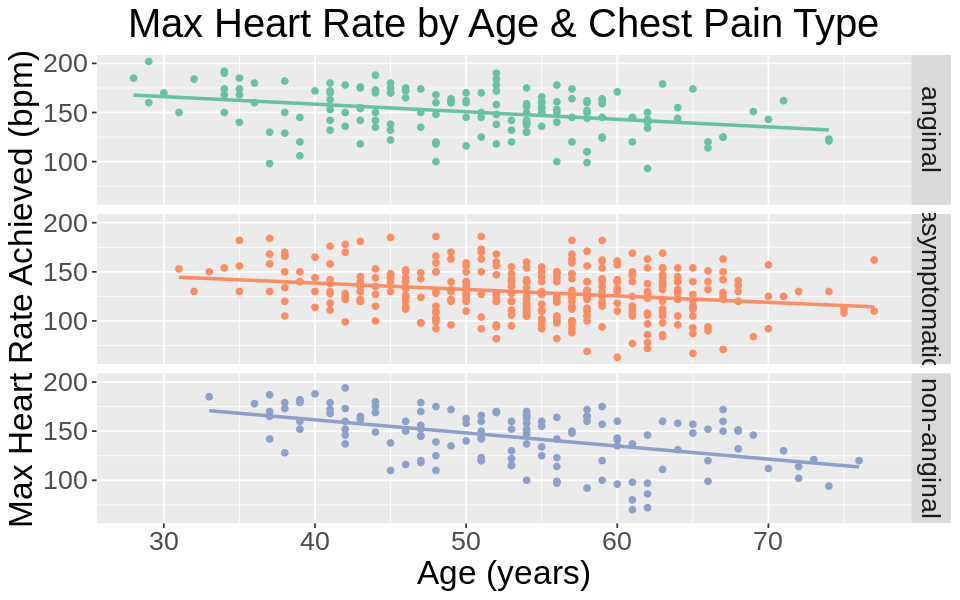

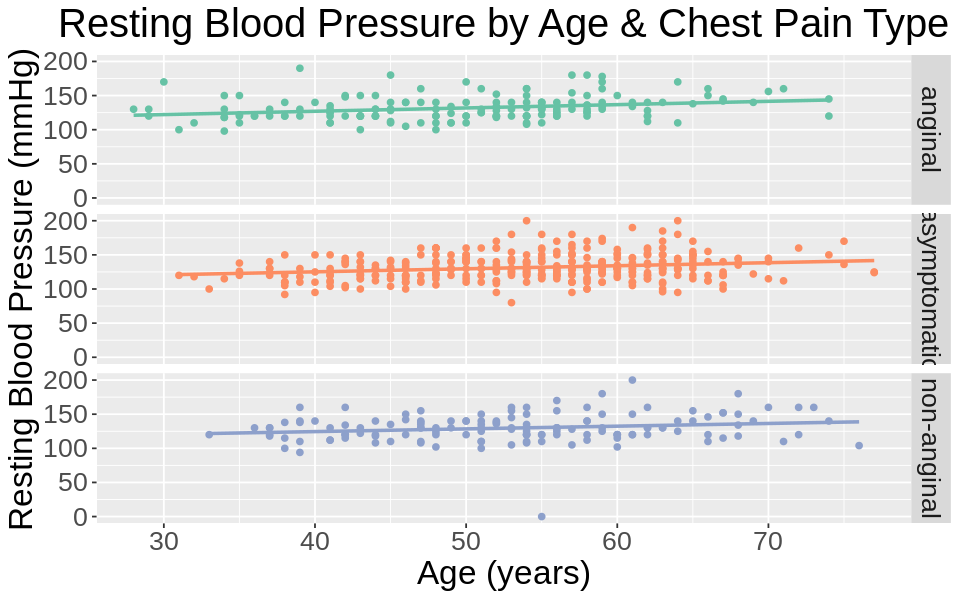

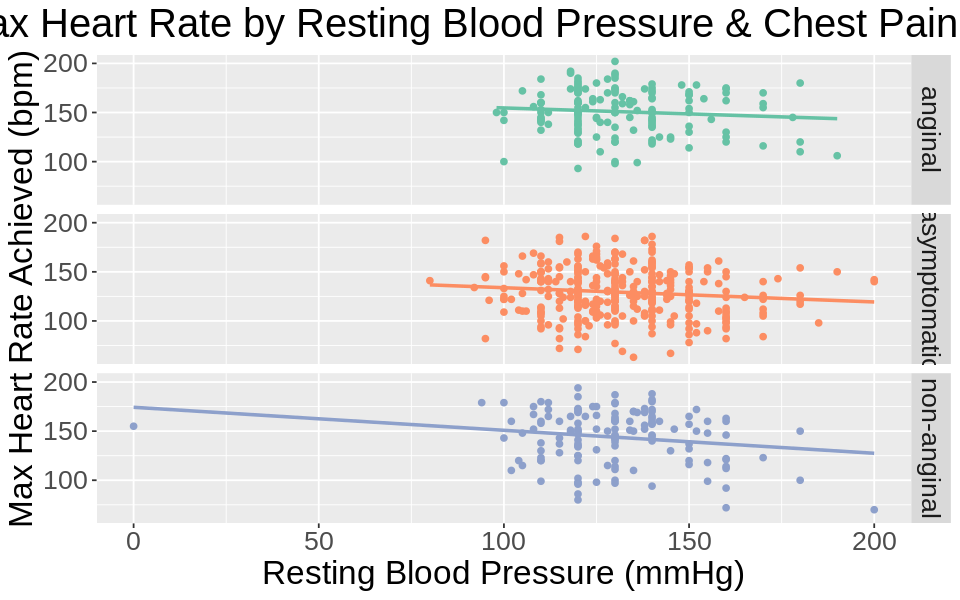

In [13]:
options(repr.plot.width = 8, repr.plot.height = 5)

hr_age_plot <- ggplot(heart_disease_train, aes(x = age, y = max_hr, color = cp_type)) +
                geom_point(show.legend = FALSE) +
                labs(x = "Age (years)", y = "Max Heart Rate Achieved (bpm)", color = "Chest Pain Type") +
                ggtitle("Max Heart Rate by Age & Chest Pain Type") +
                facet_grid(rows = vars(cp_type)) +
                geom_smooth(method = "lm", se = FALSE, formula = y ~ x, show.legend = FALSE) +
                scale_color_brewer(palette = "Set2") +
                theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
suppressWarnings(print(hr_age_plot))

bp_age_plot <- ggplot(heart_disease_train, aes(x = age, y = rest_bp, color = cp_type)) +
                geom_point(show.legend = FALSE) +
                labs(x = "Age (years)", y = "Resting Blood Pressure (mmHg)", color = "Chest Pain Type") +
                ggtitle("Resting Blood Pressure by Age & Chest Pain Type") +
                facet_grid(rows = vars(cp_type)) +
                geom_smooth(method = "lm", se = FALSE, formula = y ~ x, show.legend = FALSE) +
                scale_color_brewer(palette = "Set2") +
                theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
suppressWarnings(print(bp_age_plot))

hr_bp_plot <- ggplot(heart_disease_train, aes(x = rest_bp, y = max_hr, color = cp_type)) +
                geom_point(show.legend = FALSE) +
                labs(x = "Resting Blood Pressure (mmHg)", y = "Max Heart Rate Achieved (bpm)", color = "Chest Pain Type") +
                ggtitle("Max Heart Rate by Resting Blood Pressure & Chest Pain Type") +
                facet_grid(rows = vars(cp_type)) +
                geom_smooth(method = "lm", se = FALSE, formula = y ~ x, show.legend = FALSE) +
                scale_color_brewer(palette = "Set2") +
                theme(text = element_text(size = 20), plot.title = element_text(hjust = 0.5))
suppressWarnings(print(hr_bp_plot))

      3 age: age in years
      4 sex: sex (1 = male; 0 = female)
      9 cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic
     10 trestbps: resting blood pressure (in mm Hg on admission to the 
        hospital)
     12 chol: serum cholestoral in mg/dl
     16 fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
     19 restecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST 
                    elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy
                    by Estes' criteria
     32 thalach: maximum heart rate achieved
     38 exang: exercise induced angina (1 = yes; 0 = no)
     40 oldpeak = ST depression induced by exercise relative to rest
     41 slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
     44 ca: number of major vessels (0-3) colored by flourosopy
     51 thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
     58 num: diagnosis of heart disease (angiographic disease status)
        -- Value 0: < 50% diameter narrowing
        -- Value 1: > 50% diameter narrowing
        (in any major vessel: attributes 59 through 68 are vessels)

9. Missing Attribute Values: Several.  Distinguished with value -9.0.